# Installing libraries and extracting data from drive

In [1]:
!pip install gdown
!gdown --id 1iOdA7wG3kKk3OgPDSC4Z4014eCoCKV6C

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1iOdA7wG3kKk3OgPDSC4Z4014eCoCKV6C
To: /content/sudoku.csv
100% 164M/164M [00:01<00:00, 88.2MB/s]


# Libraries

In [2]:
import numpy as np
from math import sqrt
from random import shuffle, randint, uniform, sample
import time

# Reading the 1 mill Sudoku file

In [3]:
"""
Code snippet to extract sudokus from file 'sudoku.csv'
https://www.kaggle.com/datasets/bryanpark/sudoku
"""

quizzes = np.zeros((1000000, 81), np.int32)
solutions = np.zeros((1000000, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        quizzes[i, j] = q
        solutions[i, j] = s
quizzes = quizzes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))

## Test sudoku

In [4]:
s = list([list(i) for i in quizzes[0]])
s

[[0, 0, 4, 3, 0, 0, 2, 0, 9],
 [0, 0, 5, 0, 0, 9, 0, 0, 1],
 [0, 7, 0, 0, 6, 0, 0, 4, 3],
 [0, 0, 6, 0, 0, 2, 0, 8, 7],
 [1, 9, 0, 0, 0, 7, 4, 0, 0],
 [0, 5, 0, 0, 8, 3, 0, 0, 0],
 [6, 0, 0, 0, 0, 0, 1, 0, 5],
 [0, 0, 3, 5, 0, 8, 6, 9, 0],
 [0, 4, 2, 9, 1, 0, 3, 0, 0]]

## test sudoku's solution

In [5]:
sol = solutions[0]
sol

array([[8, 6, 4, 3, 7, 1, 2, 5, 9],
       [3, 2, 5, 8, 4, 9, 7, 6, 1],
       [9, 7, 1, 2, 6, 5, 8, 4, 3],
       [4, 3, 6, 1, 9, 2, 5, 8, 7],
       [1, 9, 8, 6, 5, 7, 4, 3, 2],
       [2, 5, 7, 4, 8, 3, 9, 1, 6],
       [6, 8, 9, 7, 3, 4, 1, 2, 5],
       [7, 1, 3, 5, 2, 8, 6, 9, 4],
       [5, 4, 2, 9, 1, 6, 3, 7, 8]], dtype=int32)

In [ ]:
"""  test = [[6, 1, 4, 2, 8, 5, 3, 7, 9], 
    [3, 2, 8, 4, 5, 9, 7, 6, 1], 
    [2, 6, 9, 8, 7, 1, 5, 4, 3], 
    [7, 3, 6, 1, 9, 4, 8, 5, 2], 
    [5, 6, 2, 1, 9, 7, 4, 8, 3], 
    [2, 8, 7, 4, 6, 9, 5, 3, 1], 
    [6, 1, 7, 9, 8, 3, 5, 4, 2], 
    [4, 2, 3, 5, 7, 8, 9, 1, 6], 
    [1, 8, 5, 6, 9, 7, 3, 4, 2]] """

'  test = [[6, 1, 4, 2, 8, 5, 3, 7, 9], \n    [3, 2, 8, 4, 5, 9, 7, 6, 1], \n    [2, 6, 9, 8, 7, 1, 5, 4, 3], \n    [7, 3, 6, 1, 9, 4, 8, 5, 2], \n    [5, 6, 2, 1, 9, 7, 4, 8, 3], \n    [2, 8, 7, 4, 6, 9, 5, 3, 1], \n    [6, 1, 7, 9, 8, 3, 5, 4, 2], \n    [4, 2, 3, 5, 7, 8, 9, 1, 6], \n    [1, 8, 5, 6, 9, 7, 3, 4, 2]] '

# Genetic Algorithm

In [6]:
def transform(problem_grid):
    """
    Transforms the problem_grid passed, testing the sudoku has three main comparisons.
      Assuming we have an untransformed grid, we have:
        1. All rows must have each number from 1 to 9 with no repetition
        2. All columns must have each number from 1 to 9 wtih no repetition
        3. All 3x3 squares must have each number from 1 to 9 with no repetition
      These last conditions are assuming we have a 9x9 grid with 81 numbers in total. 

      To be able to easily check for rows, columns and squares, we transform the grid, to convert each 3x3 square to a 1x9 row. 
      These way in the untransformed version we check rows and columns
      In the transformed version we check rows, and now we have checked every condition.
    Parameters:
      - problem_grid (list): Sudoku grid (Transformed or Untransformed).
    Returns (list).
      - transformed grid .
          If problem_grid is the original sudoku it converts it
          If the problem_grid is the already transformed sudoku, it unrolls it
    """
    file_lines = problem_grid
    problem_grid = [[] for i in range(len(file_lines))] #Empty grid
    sqrt_n = 3 # this parameter could change if one wants to generalize for sudokus of other dimensions
    for j in range(len(file_lines)): 
        line_values = [(int(value) if value != 0 else None) for value in file_lines[j]]
        for i in range(len(line_values)):
            problem_grid[
                int(i / sqrt_n) +
                int(j / sqrt_n) * sqrt_n
                ].append(line_values[i])
        
    return problem_grid

In [7]:
def solve(problem_grid, population_size=10000, selection_rate=0.8, max_generations_count=100, mutation_rate=0.4, random_proportion=0.5, verbose=False):
    """
    Solves a Sudoku puzzle using a genetic algorithm.
    It receives a problem grid written in differentes lines (Not one line with 81 numbers) and in the empty spaces, a 0 should appear
    In the "reading sudoku" chapter there is an example of how the initial sudoku should be formatted.

    Parameters:
        - problem_grid (list): An 9x9 sudoku grid.
        - population_size (int): The initial population size.
        - selection_rate (int)
        - max_generations_count (int)
        - mutation_rate (int)
      Returns:
        - population[0] (list): Solved sudoku.
        - best_fitness (int): last best_fitness, when not solved in the max_generations it gets the last one.
        - fitness_history (list): For plotting progress of learning
    """
    
    problem_grid = transform(problem_grid)
    
    def empty_grid(elem_generator=None):
        """
        Returns an empty Sudoku grid.
        Parameters:
        - elem_generator (function) (optional=None): Is is used to generate initial values of the grid's elements.
              If it's not given, all grid's elements will be "None".
        """
        return [
            [
                (None if elem_generator is None else elem_generator(i, j))
                for j in range(len(problem_grid))
            ] for i in range(len(problem_grid))
        ]

    def deep_copy_grid(grid):
        """
        Returns a deep copy of the grid argument.
        The reason why there is an empty grid and the a deep copy of a grid is the way python works with lists.
        For example, sample function and normal assignation of none to a list could modify the original list where
        it was defined from.
        By deep copying an empty grid we make sure, the original grid is not modified.
        Parameters:
            - grid (list)
        """

        return empty_grid(lambda i, j: grid[i][j])

    problem_grid = deep_copy_grid(problem_grid)

    def fitness(grid):
        """
        Calculates the fitness function for a grid, the fitness integer is the number of repeated elements,
        either in a row, column or square.
        Parameters:
            - grid (list)
        Returns (int): The value of the fitness function for the input grid.
        """
        grid = np.array(grid)
        grid_2 = transform(grid) # Transforming

        ################# COUNT HOW MANY REPEATED NUMBERS ############################
        row = np.sum(9 - np.array([len(np.unique(r)) for r in grid_2]))
        column = np.sum(9 - np.array([len(np.unique(c)) for c in np.transpose(grid_2)]))
        square = np.sum(9 - np.array([len(np.unique(r)) for r in grid]))

        # Verification of given values
        actual = sum(x is not None for x in np.array(problem_grid).flatten()) - np.sum(np.array(problem_grid).flatten() == np.array(grid).flatten())
        ftns = row + column + square + actual

        return ftns

    def generate_initial_population(pop_size):
        """
        Generates an initial population of size "population_size".
        Returns (list): An array of candidate grids.
        """

        candidates = []

        for k in range(pop_size):
            candidate = empty_grid()
            for i in range(len(problem_grid)):
                shuffled_sub_grid = [n for n in range(1, len(problem_grid) + 1)]
                shuffle(shuffled_sub_grid)

                for j in range(len(problem_grid)):
                    if problem_grid[i][j] is not None:
                        candidate[i][j] = problem_grid[i][j]

                        shuffled_sub_grid.remove(problem_grid[i][j])

                for j in range(len(problem_grid)):
                    if candidate[i][j] is None:
                        candidate[i][j] = shuffled_sub_grid.pop()

            candidates.append(candidate)

        return candidates

    def selection(candidates):
        """
        Returns the best portion ("selection_rate") of candidates based on their fitness function values (lower ones).
        Parameters:
          - candidates (list)
        Returns:
          - ordered candidates (list)
          - fitness of the first candidate (int)
          - fitness of the last candidate (int)
        """

        index_fitness = []
        for i in range(len(candidates)):
            index_fitness.append(tuple([i, fitness(candidates[i])]))
        index_fitness.sort(key=lambda elem: elem[1])

        selected_part = index_fitness[0: int(len(index_fitness) * selection_rate)]
        indexes = [e[0] for e in selected_part]

        return [candidates[i] for i in indexes], selected_part[0][1], selected_part[-1][1]

    population = generate_initial_population(population_size)
    best_fitness = 100 # initializing value with an unprobable value
    fitness_history = [] # for plotting
    
    for i in range(max_generations_count):
        prev_fitness = best_fitness
        population, best_fitness, worst_fitness = selection(population) # selecting the best (selection_rate*populationz_size) candidates.
        if best_fitness == 0:  # IF fitness equal to 0, then the solution has no flaws.
            print('Generation {} -Best candidate\'s fitness {} -Worst candidate\'s fitness {}'.format(i, best_fitness, worst_fitness))
            break
        
        actual_pop_size = len(population)

        new_population_size = int((population_size - actual_pop_size)*(1-random_proportion))
        random_population_size = int((population_size - actual_pop_size)*random_proportion)

        new_population = []

        #Cross-over
        for j in range(new_population_size):
            # Selecting two random candidates
            w1 = randint(0, actual_pop_size - 1)
            w2 = randint(0, actual_pop_size - 1)
            c1 = population[w1].copy() # Copy to avoid manipulating original list
            c2 = population[w2].copy()

            #Random cross-over
            cross_point = randint(0, 8)
            temp = c2[cross_point]
            c1[cross_point] = c2[cross_point] # Here we exchange a random row(That it was orginally a square) from the first grid with another row from the second grid
            c2[cross_point] = temp

            if fitness(c1) < fitness(c2): # comparing best fitness of the two changes
                new_population.append(c1) # only appending the best candidate of the cross-over
            else:
                new_population.append(c2)

        random_population = generate_initial_population(random_population_size)

        # Mutation
        for candidate in new_population:
            if uniform(0, 1) < mutation_rate:
                random_sub_grid = randint(0, 8)
                possible_swaps = []
                for grid_element_index in range(len(problem_grid)):
                    if problem_grid[random_sub_grid][grid_element_index] is None:
                        possible_swaps.append(grid_element_index)
                if len(possible_swaps) > 1:
                    shuffle(possible_swaps)
                    first_index = possible_swaps.pop()
                    second_index = possible_swaps.pop()
                    tmp = candidate[random_sub_grid][first_index]
                    candidate[random_sub_grid][first_index] = candidate[random_sub_grid][second_index]
                    candidate[random_sub_grid][second_index] = tmp

        new_population = np.append(new_population, random_population, 0)

        population = np.append(population, new_population, 0)
        
        fitness_history.append(best_fitness)
        if verbose:
             print('Generation {} -Best candidate\'s fitness {} -Worst candidate\'s fitness {}'.format(i, best_fitness, worst_fitness)) # This is used to see progress in console of the solving

        # Resetting if local minimum
        if len(fitness_history) > 60 and len(np.unique(fitness_history[-49:])) == 1:
          print(population[0])
          population = generate_initial_population(population_size) # Create a whole new random population if last 20 fitness has not changed


        
    population, best_fitness, worst_fitness = selection(population)
    return population[0], best_fitness, fitness_history

# Solving

In [8]:
solution, best_fitness, fit_history = solve(s, selection_rate=0.05, mutation_rate = 0.6, random_proportion=0.6, max_generations_count=200, verbose=True)

Generation 0 -Best candidate's fitness 25 -Worst candidate's fitness 36
Generation 1 -Best candidate's fitness 21 -Worst candidate's fitness 32
Generation 2 -Best candidate's fitness 20 -Worst candidate's fitness 27
Generation 3 -Best candidate's fitness 17 -Worst candidate's fitness 23
Generation 4 -Best candidate's fitness 15 -Worst candidate's fitness 20
Generation 5 -Best candidate's fitness 11 -Worst candidate's fitness 17
Generation 6 -Best candidate's fitness 9 -Worst candidate's fitness 15
Generation 7 -Best candidate's fitness 6 -Worst candidate's fitness 12
Generation 8 -Best candidate's fitness 4 -Worst candidate's fitness 9
Generation 9 -Best candidate's fitness 4 -Worst candidate's fitness 7
Generation 10 -Best candidate's fitness 2 -Worst candidate's fitness 5
Generation 11 -Best candidate's fitness 2 -Worst candidate's fitness 4
Generation 12 -Best candidate's fitness 2 -Worst candidate's fitness 2
Generation 13 -Best candidate's fitness 2 -Worst candidate's fitness 2
Ge

In [9]:
solution, best_fitness, fit_history_2 = solve(s, selection_rate=0.5, mutation_rate = 0.8, max_generations_count=200)

Generation 42 -Best candidate's fitness 0 -Worst candidate's fitness 9


In [ ]:
import matplotlib.pyplot as plt

In [10]:
plt.plot(fit_history)
plt.plot(fit_history_2)
plt.show()

NameError: ignored

Generation 28 -Best candidate's fitness 0 -Worst candidate's fitness 12
Generation 33 -Best candidate's fitness 0 -Worst candidate's fitness 10
Generation 29 -Best candidate's fitness 0 -Worst candidate's fitness 10
Generation 36 -Best candidate's fitness 0 -Worst candidate's fitness 9
Generation 39 -Best candidate's fitness 0 -Worst candidate's fitness 7
Generation 37 -Best candidate's fitness 0 -Worst candidate's fitness 8
Generation 33 -Best candidate's fitness 0 -Worst candidate's fitness 10
Generation 30 -Best candidate's fitness 0 -Worst candidate's fitness 12
Generation 35 -Best candidate's fitness 0 -Worst candidate's fitness 8
Generation 32 -Best candidate's fitness 0 -Worst candidate's fitness 10
Generation 36 -Best candidate's fitness 0 -Worst candidate's fitness 8
Generation 33 -Best candidate's fitness 0 -Worst candidate's fitness 9
Generation 34 -Best candidate's fitness 0 -Worst candidate's fitness 10
Generation 33 -Best candidate's fitness 0 -Worst candidate's fitness 1

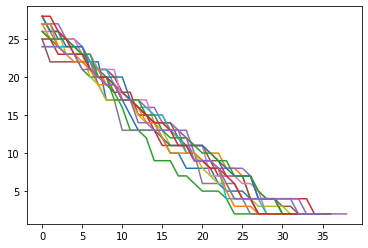

In [ ]:
f_h = []
for i in range(1, 6):
  solution, best_fitness, fit_history_3 = solve(s, selection_rate=0.5, mutation_rate = 0.5, max_generations_count=200)
  f_h.append(fit_history_3)
  plt.plot(fit_history_3)
plt.show()

In [ ]:
f_h = {}
sr = [0.1, 0.3, 0.5]
# sr = [0.1]
mr = [0.1, 0.5, 0.9]
# mr = [0.9]
rp = [0.3, 0.6]
# rp = [0.6]
for x in sr:
  for y in mr:
    for z in rp:
      f_t = []
      for i in range(1, 4):
        solution, best_fitness, fit_history_3 = solve(s, selection_rate=x, mutation_rate = y, random_proportion=z, max_generations_count=200)
        f_t.append(fit_history_3)
      f_h[str([x, y, z])] = [len(r) for r in f_t]
f_h

Generation 9 -Best candidate's fitness 0 -Worst candidate's fitness 7
Generation 12 -Best candidate's fitness 0 -Worst candidate's fitness 4
Generation 9 -Best candidate's fitness 0 -Worst candidate's fitness 6
Generation 25 -Best candidate's fitness 0 -Worst candidate's fitness 2
Generation 52 -Best candidate's fitness 0 -Worst candidate's fitness 6
Generation 14 -Best candidate's fitness 0 -Worst candidate's fitness 2
Generation 11 -Best candidate's fitness 0 -Worst candidate's fitness 4
Generation 11 -Best candidate's fitness 0 -Worst candidate's fitness 5
Generation 12 -Best candidate's fitness 0 -Worst candidate's fitness 2
Generation 12 -Best candidate's fitness 0 -Worst candidate's fitness 6
Generation 15 -Best candidate's fitness 0 -Worst candidate's fitness 5
Generation 13 -Best candidate's fitness 0 -Worst candidate's fitness 5
Generation 12 -Best candidate's fitness 0 -Worst candidate's fitness 6
Generation 12 -Best candidate's fitness 0 -Worst candidate's fitness 5
Generati

{'[0.1, 0.1, 0.3]': [9, 12, 9],
 '[0.1, 0.1, 0.6]': [25, 52, 14],
 '[0.1, 0.5, 0.3]': [11, 11, 12],
 '[0.1, 0.5, 0.6]': [12, 15, 13],
 '[0.1, 0.9, 0.3]': [12, 12, 11],
 '[0.1, 0.9, 0.6]': [14, 13, 13],
 '[0.3, 0.1, 0.3]': [16, 19, 18],
 '[0.3, 0.1, 0.6]': [21, 22, 25],
 '[0.3, 0.5, 0.3]': [18, 16, 16],
 '[0.3, 0.5, 0.6]': [22, 24, 21],
 '[0.3, 0.9, 0.3]': [20, 19, 21],
 '[0.3, 0.9, 0.6]': [28, 29, 26],
 '[0.5, 0.1, 0.3]': [26, 24, 24],
 '[0.5, 0.1, 0.6]': [32, 42, 46],
 '[0.5, 0.5, 0.3]': [32, 27, 26],
 '[0.5, 0.5, 0.6]': [36, 41, 49],
 '[0.5, 0.9, 0.3]': [34, 35, 34],
 '[0.5, 0.9, 0.6]': [50, 50, 49]}

# Solution

In [ ]:
transform(solution) # proposed solution by the algoritm

[[8, 6, 4, 3, 7, 1, 2, 5, 9],
 [3, 2, 5, 8, 4, 9, 7, 6, 1],
 [9, 7, 1, 2, 6, 5, 8, 4, 3],
 [4, 3, 6, 1, 9, 2, 5, 8, 7],
 [1, 9, 8, 6, 5, 7, 4, 3, 2],
 [2, 5, 7, 4, 8, 3, 9, 1, 6],
 [6, 8, 9, 7, 3, 4, 1, 2, 5],
 [7, 1, 3, 5, 2, 8, 6, 9, 4],
 [5, 4, 2, 9, 1, 6, 3, 7, 8]]

In [ ]:
sol # solution to check

array([[8, 6, 4, 3, 7, 1, 2, 5, 9],
       [3, 2, 5, 8, 4, 9, 7, 6, 1],
       [9, 7, 1, 2, 6, 5, 8, 4, 3],
       [4, 3, 6, 1, 9, 2, 5, 8, 7],
       [1, 9, 8, 6, 5, 7, 4, 3, 2],
       [2, 5, 7, 4, 8, 3, 9, 1, 6],
       [6, 8, 9, 7, 3, 4, 1, 2, 5],
       [7, 1, 3, 5, 2, 8, 6, 9, 4],
       [5, 4, 2, 9, 1, 6, 3, 7, 8]], dtype=int32)

In these two grids we can see that the proposed algorithm reached the solution grid. 